# Desafio Natural Language Processing with Disaster Tweets

In [1]:
import pandas as pd
import numpy as np
import zipfile
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import csr_matrix
from tqdm import tqdm

In [2]:
zf = zipfile.ZipFile('./data/nlp-getting-started.zip')
train = pd.read_csv(zf.open('train.csv'))
test = pd.read_csv(zf.open('test.csv'))

In [3]:
train.head(3)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1


In [4]:
test.head(3)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


- A coluna 'keyword' tem potencial, ja que no treino e no teste tem poucos dados faltantes
    - Preencher com label 'faltante' nos faltantes

In [7]:
word_tokenize(train['text'][200])

['HAPPENING',
 'NOW',
 '-',
 'HATZOLAH',
 'EMS',
 'AMBULANCE',
 'RESPONDING',
 'WITH',
 'DUAL',
 'SIRENS',
 'AND\x89Û_',
 'https',
 ':',
 '//t.co/SeK6MQ6NJF']

In [8]:
stop_words_nltk = list(stopwords.words('english'))
count_vectorizer = CountVectorizer(stop_words='english')
count_train = count_vectorizer.fit_transform(train['text'].values)

In [9]:
csr_matrix(count_train).toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [10]:
train['text'].values[0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [11]:
# Checando a tokenizacao

word_tokenize(train['text'][0])

['Our',
 'Deeds',
 'are',
 'the',
 'Reason',
 'of',
 'this',
 '#',
 'earthquake',
 'May',
 'ALLAH',
 'Forgive',
 'us',
 'all']

## Tweet tokenizer

In [12]:
from nltk.tokenize import TweetTokenizer

def tweet_tokenize_column(df, column):
    """ 
        This function gets the Dataframe and the name of a column (String) containing texts (Strings) and returns
        a list of lists containing the tokenized text. It also turns every token to it's lower form.
        
        Input: Pandas DataFrame, String
        Return: Nested List
    """
    
    tweet_tokenizer = TweetTokenizer()
    
    # List of sentences
    list_sent = [tweet_tokenizer.tokenize(sent) for sent in df[column].values]
    
    # List of sentences excluding stopword tokens
    list_sent_no_stop = [[token.lower() 
                           for token in sent 
                           if token not in stopwords.words('english')] 
                           for sent in list_sent]
    
    
    
    return list_sent_no_stop

In [13]:
tokenized_sent_train = tweet_tokenize_column(train,'text')
tokenized_sent_test = tweet_tokenize_column(test,'text')

In [14]:
tokenized_sent_train[:2]

[['our', 'deeds', 'reason', '#earthquake', 'may', 'allah', 'forgive', 'us'],
 ['forest', 'fire', 'near', 'la', 'ronge', 'sask', '.', 'canada']]

In [15]:
tokenized_sent_test[:2]

[['just', 'happened', 'terrible', 'car', 'crash'],
 ['heard',
  '#earthquake',
  'different',
  'cities',
  ',',
  'stay',
  'safe',
  'everyone',
  '.']]

In [16]:
tokenized_sent_all = tokenized_sent_train + tokenized_sent_test

Aplicando o TF-IDF nos datasets. Esses tem como caracteristicas:
- Contem palavras somente em letra minuscula
- Nao tem stopwords
- Foi tokenizado com o TweetTokenizer

In [17]:
# Funcao auxiliar para bypass do tokenizador, uma vez que este passo ja foi feito.
def identity_tokenizer(text):
    return text

tfidf_all = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False)    
tfidf_all_fit = tfidf_all.fit_transform(tokenized_sent_all)

tfidf_all.get_feature_names()[1000:1002]


C:\Users\Rafael\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


['#hail', '#haildamage']

In [18]:
tfidf_all.get_feature_names()

['!',
 '#',
 '##book',
 '##fukushima',
 '##youtube',
 '#0215',
 '#034',
 '#039',
 '#05',
 '#0518',
 '#06',
 '#09',
 '#1-1st',
 '#1008pla',
 '#1008planet',
 '#124',
 '#12k',
 '#140',
 '#16',
 '#163',
 '#17',
 '#171',
 '#1oak',
 '#2015',
 '#20150613',
 '#21dayfix',
 '#22days',
 '#24',
 '#26',
 '#263chat',
 '#2a',
 '#2fast2furious',
 '#2minutemix',
 '#360wisenews',
 '#365disasters',
 '#3682',
 '#37592',
 '#38745',
 '#3novices',
 '#452',
 '#4552',
 '#4playthursdays',
 '#5sosfam',
 '#5sosquotes',
 '#615',
 '#629',
 '#666',
 '#7294',
 '#7news',
 '#7newsadl',
 '#8217',
 '#8392',
 '#89x',
 '#8nn',
 '#911',
 '#9973',
 '#999day',
 '#9newsmornings',
 '#aapatwork',
 '#abandoned',
 '#abbott',
 '#abc',
 '#abc7eyewitness',
 '#abcnews',
 '#abha',
 '#ableg',
 '#abomb',
 '#abstorm',
 '#acapella',
 '#accident',
 '#accidentalprophecy',
 '#acenewsdesk',
 '#achedin',
 '#acreativedc',
 '#act',
 '#action',
 '#actionmoviestaughtus',
 '#adani',
 '#addiction',
 '#addtexastonext1dtour',
 '#adiossuperbacterias',
 

In [19]:
#       token1 token2 token3
# train1
# train2
# .
# .
# trainN
# test1
# test2
# .
# .
# testN

In [20]:
# print("TF-IDF DataFrame dimensions: {}\n".format(tfidf_train_fit.toarray().shape))
# print("TF-IDF Number or Features: {}\n".format(len(tfidf_train.get_feature_names())))

Faz sentido, ja que o numero de colunas do ``tfidf_train_fit`` corresponde ao numero de tokens, e a contagem do ``tfidf_train.get_feature_names()`` tambem. 

In [21]:
tfidf_all_df = pd.DataFrame(tfidf_all_fit.toarray(), columns=tfidf_all.get_feature_names())

In [22]:
tfidf_all_df

,!,#,##book,##fukushima,##youtube,#0215,#034,#039,#05,#0518,...,ûó,ûócategorically,ûóher,ûókaiserjaegers,ûókill,ûókody,ûónegligence,ûótech,ûówe,ûówere
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10872,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10873,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10874,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
tfidf_train_df = tfidf_all_df[:len(train)]

tfidf_test_df = tfidf_all_df[len(train):]


In [24]:
tfidf_train_df["target_column"] = train['target']

<ipython-input-24-08b7743227f1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tfidf_train_df["target_column"] = train['target']


In [25]:
tfidf_train_df['target_column']

0       1
1       1
2       1
3       1
4       1
       ..
7608    1
7609    1
7610    1
7611    1
7612    1
Name: target_column, Length: 7613, dtype: int64

In [27]:
# chi

In [28]:
# mi = mutual_info_classif(tfidf_train_df_int.drop("target_column", axis=1), tfidf_train_df_int["target_column"])
# mi = pd.Series(mi)
# mi.index = intersect_columns
# mi.sort_values(ascending=False, inplace=True) 

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score

X = tfidf_train_df.drop("target_column", axis=1)
y = tfidf_train_df["target_column"]

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=16)

clf = LogisticRegression(random_state=16)

scores_logistic = cross_val_score(clf, X, y, cv=5)

In [30]:
scores_logistic.mean()

0.7047231974377979

In [31]:
from sklearn.metrics import accuracy_score

clf.fit(X,y)

y_pred = clf.predict(X)

print('Training accuracy is {}'.format(accuracy_score(y, y_pred)))

Training accuracy is 0.8903191908577434


In [38]:
# Submissao

sample_submission = pd.read_csv(zf.open('sample_submission.csv'))

y_sub = clf.predict(tfidf_test_df)

In [46]:
sub = sample_submission.copy()

In [48]:
sub['target'] = y_sub

In [58]:
sub.set_index('id',inplace=True)

In [59]:
sub

,target
id,
0,1
2,0
3,1
9,0
11,1
...,...
10861,1
10865,1
10868,1


In [60]:
sub.to_csv("./submissions/sub_01.csv")

# Selecao de atributos

In [69]:
from sklearn.feature_selection import mutual_info_classif, chi2

chi = chi2(X,y)
chi = pd.Series(chi[0])
chi.index = X.columns
chi.sort_values(ascending=False, inplace=True)    


In [70]:
chi

?                  37.196852
california         29.250636
suicide            24.139547
:                  24.103232
killed             23.600085
                     ...    
ûòdon                    NaN
ûócategorically          NaN
ûókaiserjaegers          NaN
ûókill                   NaN
ûówere                   NaN
Length: 29720, dtype: float64

In [71]:
chi.to_csv("./data/chi.csv")

In [72]:
atts = np.linspace(100,10000,100)
list_scores = []
list_var = []

for att in tqdm(atts):
    
    list_scores.append(cross_val_score(clf, X[chi[:int(att)].index], y, cv=3).mean())
    list_var.append(cross_val_score(clf, X[chi[:int(att)].index], y, cv=3).var())

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [09:59<00:00,  5.99s/it]


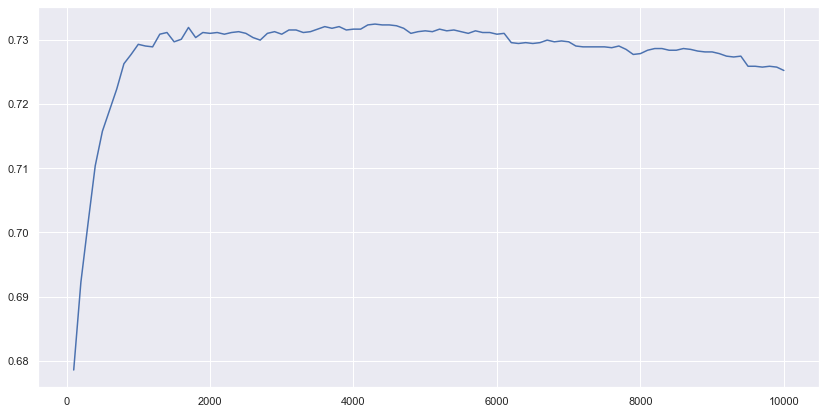

In [105]:
int_atts = [int(att) for att in atts]

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y=list_scores, x=int_atts)
# plt.axvline(x=int_atts[np.array(list_scores[5:]).argmax()+5], color='r')
# plt.xticks(ticks=np.arange(0.00, 0.25, 0.01))
plt.show()

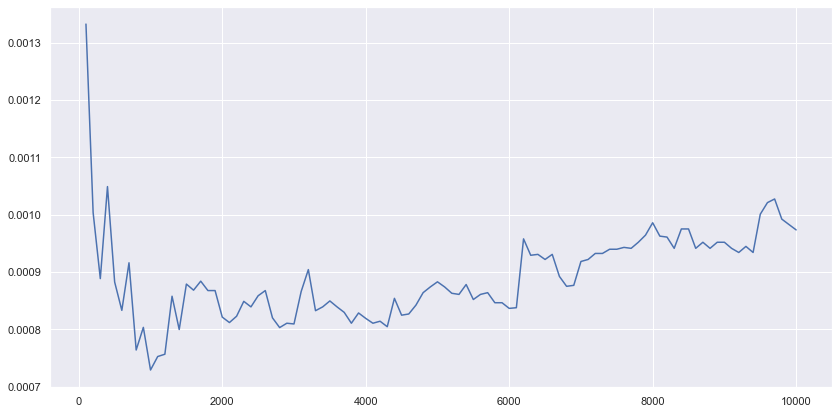

In [106]:
sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y=list_var, x=int_atts)
# plt.axvline(x=int_atts[np.array(list_var[5:]).argmin()+5], color='r')
# plt.xticks(ticks=np.arange(0.00, 0.25, 0.01))
plt.show()

In [82]:
atts = np.linspace(100,10000,100)
list_scores_over = []

for att in tqdm(atts):
    clf.fit(X[chi[:int(att)].index],y)
    y_pred = clf.predict(X[chi[:int(att)].index])
    acc = accuracy_score(y, y_pred)
    
    list_scores_over.append(acc)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [03:47<00:00,  2.28s/it]


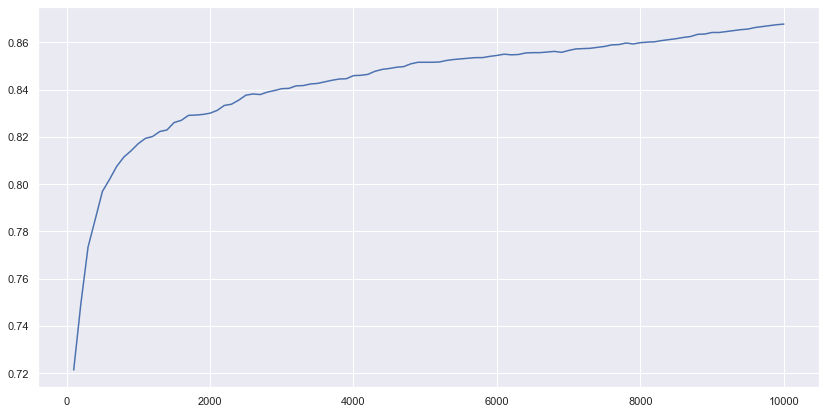

In [83]:
int_atts = [int(att) for att in atts]

sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y=list_scores_over, x=int_atts)
# plt.axvline(x=int_atts[np.array(list_scores[5:]).argmax()+5], color='r')
# plt.xticks(ticks=np.arange(0.00, 0.25, 0.01))
plt.show()

In [97]:
atts = np.linspace(100,10000,100)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16)



In [115]:
list_scores_tts = []

for att in tqdm(atts):
    clf.fit(X_train[chi[:int(att)].index],y_train)
    y_pred = clf.predict(X_test[chi[:int(att)].index])
    acc = accuracy_score(y_test , y_pred)
    
    list_scores_tts.append(acc)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:16<00:00,  1.36s/it]


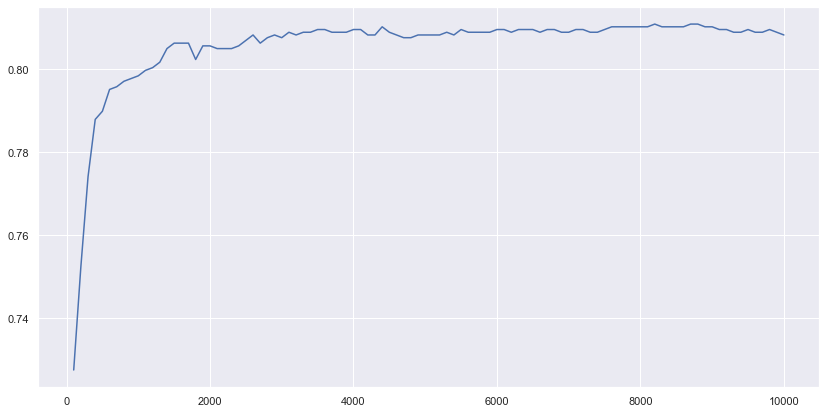

In [116]:
int_atts = [int(att) for att in atts]

sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y=list_scores_tts, x=int_atts)
# plt.axvline(x=int_atts[np.array(list_var[5:]).argmin()+5], color='r')
# plt.xticks(ticks=np.arange(0.00, 0.25, 0.01))
plt.show()

In [100]:
acc

0.7971109652002626

In [61]:
from sklearn.svm import SVC

clf_svc = SVC()

clf_svc.fit(X,y)

y_pred = clf_svc.predict(X)

print('Training accuracy is {}'.format(accuracy_score(y, y_pred)))

KeyboardInterrupt: 

In [ ]:
cross_val_score(log, X, y, cv=5, scoring='accuracy')

In [ ]:
scores_logistic_3000 = cross_val_score(clf, X[chi[:3000].index], y, cv=5)

In [ ]:
scores_logistic_3000.mean()

In [ ]:
# 

# atts = np.linspace(1,5986,200)
# list_scores = []
# list_var = []

# for att in tqdm(atts):
    
#     list_scores.append(cross_val_score(clf, X[chi[:int(att)].index], y, cv=5).mean())
#     list_var.append(cross_val_score(clf, X[chi[:int(att)].index], y, cv=5).var())
    

In [ ]:
int_atts = [int(att) for att in atts]

import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y=list_scores[5:], x=int_atts[5:])
plt.axvline(x=int_atts[np.array(list_scores[5:]).argmax()+5], color='r')
# plt.xticks(ticks=np.arange(0.00, 0.25, 0.01))
plt.show()

In [ ]:
sns.set()
plt.figure(figsize=(14,7))
sns.lineplot(y=list_var[5:], x=int_atts[5:])
plt.axvline(x=int_atts[np.array(list_var[5:]).argmin()+5], color='r')
# plt.xticks(ticks=np.arange(0.00, 0.25, 0.01))
plt.show()

In [ ]:
int_atts[np.array(list_scores).argmax()]

In [ ]:
scores_logistic_2166 = cross_val_score(clf, X[chi[:2166].index], y, cv=10)

In [ ]:
scores_logistic_2166

In [ ]:
# from sklearn.tree import DecisionTreeClassifier

# tree = DecisionTreeClassifier(criterion="entropy")

# scores_tree = cross_val_score(tree, X, y, cv=5)


In [ ]:
# scores_tree.mean()

In [ ]:
# X_tree = tfidf_df.loc[:,~(tfidf_df.columns == 'target_column')]
# Y_tree = tfidf_df.target_column

# accuracy_test = []

# kf = KFold(n_splits=10)

# X = X_tree.values
# y = Y_tree.values

# for train_index, test_index in kf.split(X_tree):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]
    
#     tree = DecisionTreeClassifier(criterion="entropy", ccp_alpha=0.001226509672564484)
    
#     tree.fit(X_train, y_train)
#     y_test_pred = tree.predict(X_test)
#     accuracy_test.append(metrics.accuracy_score(y_test, y_test_pred))


# st.t.interval(0.99, len(accuracy_test) - 1, loc=np.mean(accuracy_test), scale=st.sem(accuracy_test))

In [ ]:
from sklearn.svm import SVC
clf_svc = SVC()

scores_svc = cross_val_score(clf_svc, X[chi[:2166].index], y, cv=2)


In [ ]:
scores_svc

## To-Do
- Selecionar variaveis mais importantes (Chi^2 | Informacao Mutua)
- Selecionar colunas contendo essas variaveis tanto no treino quanto no teste
- Testar selecao de variaveis antes para todos os tokens do treino
- Testar outros modelos (SVC, NaiveBayes, RidgeClassifier, ...)
